### Importing libraries to perform convolution operations

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from keras.models import load_model

### loading cifar10 dataset and creating training and test dataset variables

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

### Cifar has 10 classes - traversing dataset and printing 10 classes images

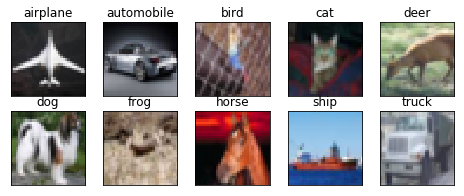

In [30]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Plot model accuracies and losses

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### predict test dataset and calculate accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Converting image values to float type and assigning lables 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Defining Model and adding image Augmentation cutout -


In [36]:
# Define the model
model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32, 32, 3))) #RF 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Convolution2D(128, 3, 3, border_mode='same')) #RF 5x5
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2))) #RF 10x10


model.add(Convolution2D(256, 3, 3, border_mode='same'))  #RF 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Convolution2D(512, 3, 3, border_mode='same'))  #RF 14x14
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(MaxPooling2D(pool_size=(2, 2)))  #RF 28x28

model.add(Convolution2D(1024, 3, 3, border_mode='same'))  #RF 30x30
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Convolution2D(256, 3, 3, border_mode='same')) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3, border_mode='same'))  
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Convolution2D(10, 1, 1, border_mode='same'))
model.add(Flatten())

model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 128)       0         
__________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# from random_eraser import get_random_eraser
# print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
pixel_level = False
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))

In [0]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/EVA_Phase1/BestModel_6A_For_9B.hdf5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=75)`
  


Epoch 1/75
390/390 [==============================] - 98s 250ms/step - loss: 1.6740 - acc: 0.4093 - val_loss: 1.9871 - val_acc: 0.4176
Epoch 2/75
390/390 [==============================] - 94s 242ms/step - loss: 1.1430 - acc: 0.5960 - val_loss: 1.0638 - val_acc: 0.6503
Epoch 3/75
390/390 [==============================] - 94s 241ms/step - loss: 0.9352 - acc: 0.6741 - val_loss: 0.8714 - val_acc: 0.7119
Epoch 4/75
390/390 [==============================] - 94s 241ms/step - loss: 0.8215 - acc: 0.7184 - val_loss: 1.0170 - val_acc: 0.6928
Epoch 5/75
390/390 [==============================] - 94s 241ms/step - loss: 0.7414 - acc: 0.7460 - val_loss: 1.4226 - val_acc: 0.6272
Epoch 6/75
390/390 [==============================] - 94s 241ms/step - loss: 0.6831 - acc: 0.7664 - val_loss: 0.9647 - val_acc: 0.7298
Epoch 7/75
390/390 [==============================] - 94s 241ms/step - loss: 0.6319 - acc: 0.7851 - val_loss: 0.7701 - val_acc: 0.7726
Epoch 8/75
390/390 [==============================] - 9

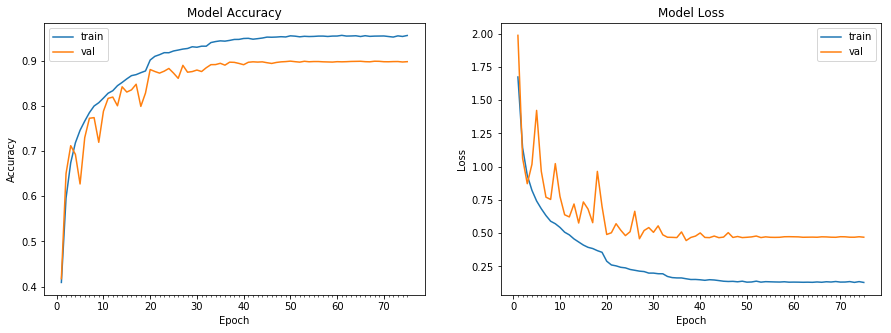

Accuracy on test data is: 89.78


In [40]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 75, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=callbacks)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [42]:
# Score trained model.
scores = model.evaluate(test_features, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 7s 748us/step
Test loss: 0.4688935120970011
Test accuracy: 0.8978


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')


# GradCam on images

In [0]:
#import required pacakeges
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
from keras.models import load_model

## Load trained model

In [0]:
model = load_model('/content/drive/My Drive/EVA_Phase1/BestModel_6A_For_9B.hdf5')

## Predict image using trained model weights and apply heatmaps- Visualise (GRAD-CAM)

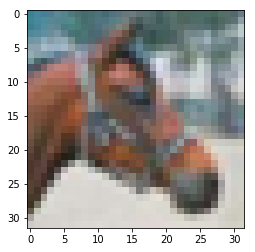

W0714 20:08:03.303197 140457217722240 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


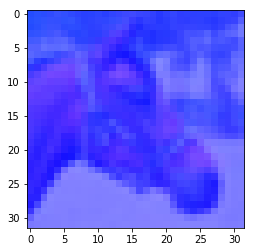

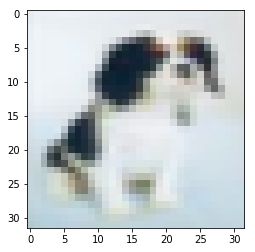

W0714 20:08:04.417585 140457217722240 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


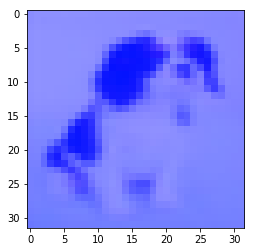

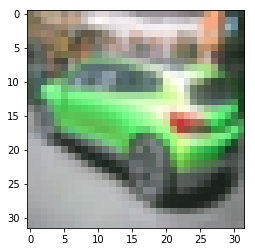

W0714 20:08:05.596640 140457217722240 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


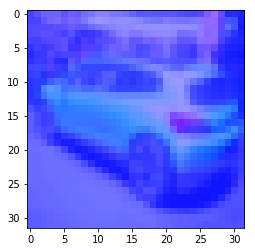

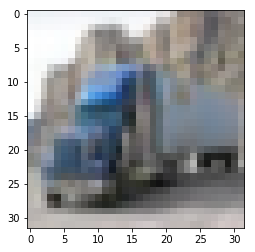

W0714 20:08:06.783679 140457217722240 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


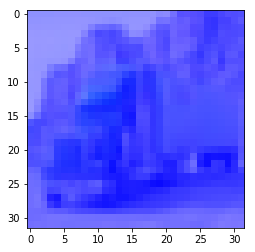

In [46]:
# choosen four images fom dataset to apply gradcam
idx = [17,212,504,440]

selected_images = [test_features[i] for i, _ in enumerate(test_features) if i in idx]
for image_path in selected_images:
  x = np.expand_dims(image_path, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_16")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
#   here range is 4 as we have choosen 4 images
  for i in range(4):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)# get heatmap on range
    img = image_path
#     img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4,0,dtype = cv2.CV_32F)
    
  plt.imshow(img)
  plt.show() 
  plt.imshow(superimposed_img)
  plt.show()